In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from scipy.stats import skew
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
# Load dataset
df= pd.read_csv("diabetic_data.csv")

In [3]:
# Data head
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Dropping the columns

In [4]:
df.drop(['weight','payer_code','encounter_id', 'patient_nbr'],axis=1,inplace=True)

### Replacing the missing values

In [5]:
# Replace missing values in the race column with the most frequent value
df['race'] = df['race'].fillna(df['race'].mode()[0])

In [6]:
# Replace missing values in the 'medical_specialty' column with the mode of the column
df['medical_specialty'] = df['medical_specialty'].fillna(df['medical_specialty'].mode()[0])

In [7]:
import re #regex!

# Define a function to clean the age column
def clean_age(age):
    age = str(age) # Convert to string
    age = re.sub('[^0-9\-]', '', age) # Remove any non-numeric characters
    age = age.split('-') # Split the string into a list of values
    age = [int(x) for x in age if x != ''] # Convert each value to an integer and remove any empty strings
    if len(age) == 1:
        return age[0]
    else:
        return sum(age)/2 # Return the average of the lower and upper bounds of the age group

# Apply the clean_age function to the age column
df['age'] = df['age'].apply(clean_age)

In [8]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)


## Label Encoding

In [9]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['readmitted']= label_encoder.fit_transform(df['readmitted'])

df['readmitted'].unique()


array([2, 1, 0])

In [10]:
df['readmitted']

0         2
1         1
2         2
3         2
4         2
         ..
101761    1
101762    2
101763    2
101764    2
101765    2
Name: readmitted, Length: 101766, dtype: int32

### Feature Engg.

In [11]:
# Combine the diagnosis codes
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].replace('?', np.nan) # Replace '?' with NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert the column to a numerical column
    df.loc[(df[col] >= 390) & (df[col] < 400), col] = 1 # Circulatory system
    df.loc[(df[col] >= 401) & (df[col] < 410), col] = 2 # Respiratory system
    df.loc[(df[col] >= 410) & (df[col] < 460) | (df[col] == 785), col] = 3 # Digestive system
    df.loc[(df[col] >= 460) & (df[col] < 520) | (df[col] == 786), col] = 4 # Musculoskeletal system
    df.loc[(df[col] >= 520) & (df[col] < 580) | (df[col] == 787), col] = 5 # Genitourinary system
    df.loc[(df[col] >= 580) & (df[col] < 630) | (df[col] == 788), col] = 6 # Neoplasms
    df.loc[(df[col] >= 800) & (df[col] < 1000), col] = 7 # Injury and poisoning
    df.loc[(df[col] >= 710) & (df[col] < 740), col] = 8 # Congenital anomalies
    df.loc[(df[col] >= 140) & (df[col] < 240), col] = 9 # Other
    df.loc[(df[col] >= 240) & (df[col] < 280), col] = 10 # Other
    df.loc[(df[col] >= 680) & (df[col] < 710) | (df[col] >= 782) & (df[col] < 784) | (df[col] >= 790) & (df[col] < 800) | (df[col] >= 240) & (df[col] < 250), col] = 11 # Other
    df[col] = df[col].astype('category') # Convert the column to a categorical column


In [12]:
df_n= df
df_n.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_group
0,Caucasian,Female,5.0,6,25,1,1,Pediatrics-Endocrinology,41,0,...,No,No,No,No,No,No,No,No,2,0-20
1,Caucasian,Female,15.0,1,1,7,3,?,59,0,...,Up,No,No,No,No,No,Ch,Yes,1,0-20
2,AfricanAmerican,Female,25.0,1,1,7,2,?,11,5,...,No,No,No,No,No,No,No,Yes,2,20-30
3,Caucasian,Male,35.0,1,1,7,2,?,44,1,...,Up,No,No,No,No,No,Ch,Yes,2,30-40
4,Caucasian,Male,45.0,1,1,7,1,?,51,0,...,Steady,No,No,No,No,No,Ch,Yes,2,40-50


In [13]:
from sklearn.preprocessing import LabelEncoder
le_metformin= LabelEncoder()
df_n['le_metformin']= le_metformin.fit_transform(df_n['metformin'])
df_n.le_metformin.tail()

101761    2
101762    1
101763    2
101764    1
101765    1
Name: le_metformin, dtype: int32

In [14]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report

## Lasso Regression

In [15]:
# Perform Lasso regression to select the most relevant features
X = df.select_dtypes(include=np.number)
y = df['readmitted']
model = Lasso(alpha=0.1)
model.fit(X, y)
features = X.columns
selected_features = features[model.coef_ != 0]
print('Selected features:', selected_features)

Selected features: Index(['num_lab_procedures', 'readmitted'], dtype='object')


## Random Forest

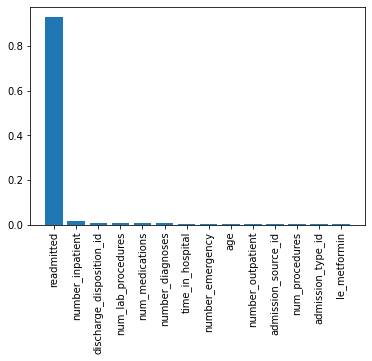

In [16]:
# Perform Random Forest classification to determine feature importances
clf = RandomForestClassifier()
clf.fit(X, y)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation='vertical')
plt.show()

## train test split

In [18]:
#split dataset in features and target variable
feature_cols = ['age','time_in_hospital', 'num_medications', 'num_lab_procedures','num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient']

X = df_n[feature_cols] # Features
y = df_n.readmitted # Target variable

In [19]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


## Decision Tree

criterion : optional (default=”gini”) or Choose attribute selection measure. This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

splitter : string, optional (default=”best”) or Split Strategy. This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth : int or None, optional (default=None) or Maximum Depth of a Tree. The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

In [20]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [21]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
report_CT_ENT = classification_report(y_test, y_pred)
print("Classification report:\n", report_CT_ENT)


Accuracy: 0.5676056338028169
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3320
           1       0.48      0.20      0.29     10661
           2       0.58      0.92      0.71     16549

    accuracy                           0.57     30530
   macro avg       0.35      0.37      0.33     30530
weighted avg       0.48      0.57      0.49     30530



Model accuracy score with criterion entropy: 0.5676


[Text(0.5, 0.875, 'X[7] <= 0.5\nentropy = 1.366\nsamples = 71236\nvalue = [8037, 24884, 38315]'),
 Text(0.25, 0.625, 'X[5] <= 0.5\nentropy = 1.257\nsamples = 47423\nvalue = [4059, 14269, 29095]'),
 Text(0.125, 0.375, 'X[6] <= 0.5\nentropy = 1.24\nsamples = 41455\nvalue = [3521, 11898, 26036]'),
 Text(0.0625, 0.125, 'entropy = 1.228\nsamples = 39198\nvalue = [3272, 10977, 24949]'),
 Text(0.1875, 0.125, 'entropy = 1.386\nsamples = 2257\nvalue = [249, 921, 1087]'),
 Text(0.375, 0.375, 'X[3] <= 23.5\nentropy = 1.336\nsamples = 5968\nvalue = [538, 2371, 3059]'),
 Text(0.3125, 0.125, 'entropy = 1.262\nsamples = 1459\nvalue = [115, 476, 868]'),
 Text(0.4375, 0.125, 'entropy = 1.352\nsamples = 4509\nvalue = [423, 1895, 2191]'),
 Text(0.75, 0.625, 'X[7] <= 2.5\nentropy = 1.481\nsamples = 23813\nvalue = [3978, 10615, 9220]'),
 Text(0.625, 0.375, 'X[7] <= 1.5\nentropy = 1.447\nsamples = 18933\nvalue = [2690, 8230, 8013]'),
 Text(0.5625, 0.125, 'entropy = 1.428\nsamples = 13680\nvalue = [1790, 572

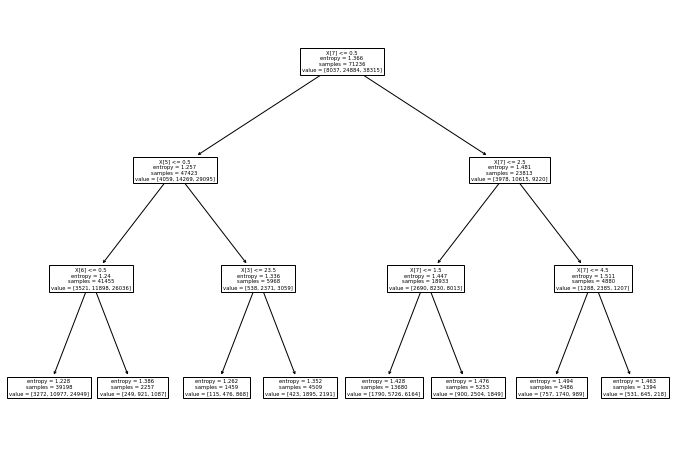

In [22]:
from sklearn.metrics import accuracy_score
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf.predict(X_train)
y_pred_train
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(X_train, y_train))

In [23]:
# Create Decision Tree classifer object
clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=3)

# Train Decision Tree Classifer
clf_gini = clf_gini.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_gini.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
report_CT_G = classification_report(y_test, y_pred)
print("Classification report:\n", report_CT_G)


Accuracy: 0.5726826072715362
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3320
           1       0.49      0.26      0.34     10661
           2       0.59      0.89      0.71     16549

    accuracy                           0.57     30530
   macro avg       0.36      0.38      0.35     30530
weighted avg       0.49      0.57      0.50     30530



[Text(0.5, 0.875, 'X[7] <= 0.5\ngini = 0.576\nsamples = 71236\nvalue = [8037, 24884, 38315]'),
 Text(0.25, 0.625, 'X[5] <= 0.5\ngini = 0.526\nsamples = 47423\nvalue = [4059, 14269, 29095]'),
 Text(0.125, 0.375, 'X[6] <= 0.5\ngini = 0.516\nsamples = 41455\nvalue = [3521, 11898, 26036]'),
 Text(0.0625, 0.125, 'gini = 0.509\nsamples = 39198\nvalue = [3272, 10977, 24949]'),
 Text(0.1875, 0.125, 'gini = 0.589\nsamples = 2257\nvalue = [249, 921, 1087]'),
 Text(0.375, 0.375, 'X[3] <= 23.5\ngini = 0.571\nsamples = 5968\nvalue = [538, 2371, 3059]'),
 Text(0.3125, 0.125, 'gini = 0.533\nsamples = 1459\nvalue = [115, 476, 868]'),
 Text(0.4375, 0.125, 'gini = 0.578\nsamples = 4509\nvalue = [423, 1895, 2191]'),
 Text(0.75, 0.625, 'X[7] <= 1.5\ngini = 0.623\nsamples = 23813\nvalue = [3978, 10615, 9220]'),
 Text(0.625, 0.375, 'X[5] <= 0.5\ngini = 0.605\nsamples = 13680\nvalue = [1790, 5726, 6164]'),
 Text(0.5625, 0.125, 'gini = 0.601\nsamples = 10900\nvalue = [1391, 4418, 5091]'),
 Text(0.6875, 0.125,

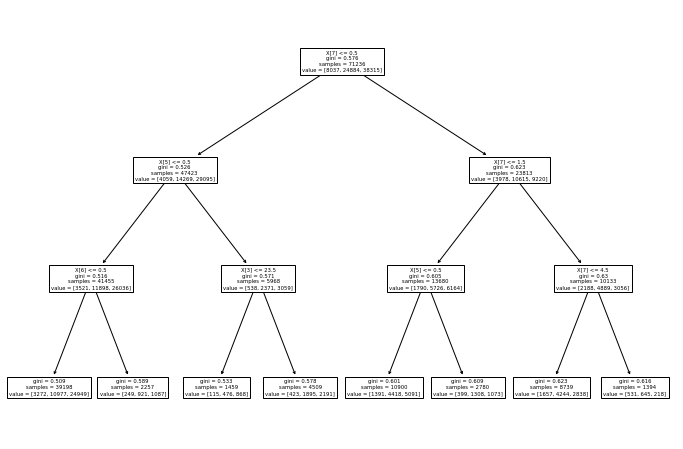

In [24]:
# Visualize decision tree
plt.figure(figsize=(12,8))
tree.plot_tree(clf_gini.fit(X_train, y_train))

## K-Nearest Neighbor

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report_KNN = classification_report(y_test, y_pred)
print("Classification report:\n", report_KNN)

Accuracy: 0.49253193580085164
Classification report:
               precision    recall  f1-score   support

           0       0.16      0.10      0.13      3320
           1       0.39      0.36      0.37     10661
           2       0.58      0.66      0.62     16549

    accuracy                           0.49     30530
   macro avg       0.38      0.37      0.37     30530
weighted avg       0.47      0.49      0.48     30530



## Gradient Boost Classifier

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the gradient boosting classifier with default parameters
clf_GB = GradientBoostingClassifier()

# Fit the classifier to the training data
clf_GB.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_GB.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report_GB = classification_report(y_test, y_pred)
print("Classification report:\n", report_GB)

Accuracy: 0.5789387487716999
Classification report:
               precision    recall  f1-score   support

           0       0.42      0.02      0.03      3320
           1       0.49      0.31      0.38     10661
           2       0.60      0.86      0.71     16549

    accuracy                           0.58     30530
   macro avg       0.51      0.40      0.38     30530
weighted avg       0.55      0.58      0.52     30530



## Gaussian Naive Bayes 

In [27]:
from sklearn.naive_bayes import GaussianNB

# Train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = nb_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report_GNB = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification report:\n", report_GNB)

Accuracy: 0.5608909269570914
Classification report:
               precision    recall  f1-score   support

           0       0.28      0.09      0.14      3320
           1       0.50      0.15      0.23     10661
           2       0.58      0.92      0.71     16549

    accuracy                           0.56     30530
   macro avg       0.46      0.39      0.36     30530
weighted avg       0.52      0.56      0.48     30530



## Model Evaluation

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

In [29]:
# Define the models to be evaluated
models = [("Decision Tree", DecisionTreeClassifier()), 
          ("Random Forest", RandomForestClassifier()), 
          ("Naive Bayes", GaussianNB()),
          "GradientBoosting",GradientBoostingClassifier(),"K-NN",KNeighborsClassifier()]

Decision Tree: AUC = nan (+/- nan)


ValueError: multiclass format is not supported

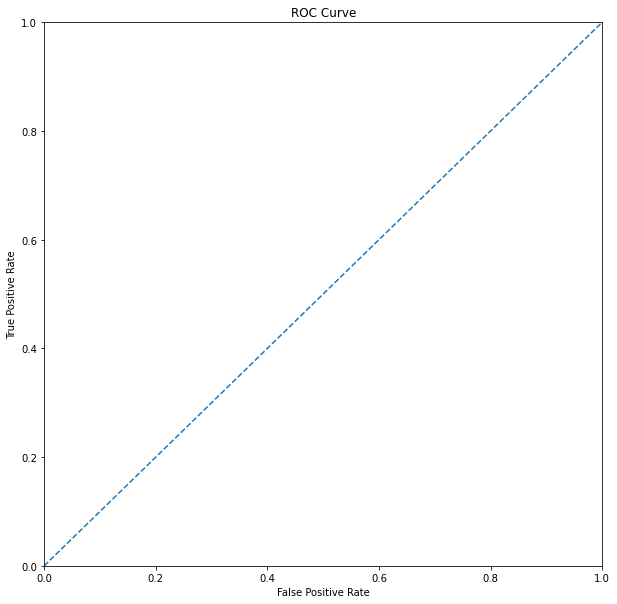

In [30]:
# Compare the performance of models using 5-fold cross-validation and ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

for name, model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
    print(f"{name}: AUC = {scores.mean():.2f} (+/- {scores.std():.2f})")
    model.fit(X, y)
    y_proba = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.legend(loc="lower right")
plt.show()